In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Collection
penguins = pd.read_csv('penguins.csv')

#clearing missing values
penguins = penguins.loc[(penguins['sex']!='?') & (penguins['sex']!='_')]

#one-hot encoding for all the categorical variables
dummies1 = pd.get_dummies(penguins.island)

dummies2 = pd.get_dummies(penguins.sex)

dummies3 = pd.get_dummies(penguins.species)


penguins = pd.concat([penguins,dummies1,dummies2,dummies3],axis='columns')
penguins = penguins.drop(['species', 'island', 'sex'], axis='columns')
display(penguins)

penguinsX= penguins.iloc[:, :9]
penguinsy= penguins.iloc[: , 9:]
print("penguinsX")
display(penguinsX)
print("penguinsy")
display(penguinsy)

penguinsX = np.array(penguinsX)
penguinsX = penguinsX.astype('float64')
penguinsy = np.array(penguinsy)
penguinsy = penguinsy.astype('float64')

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,Biscoe,Dream,Torgersen,FEMALE,MALE,Adelie,Chinstrap,Gentoo
0,39.1,18.7,181.0,3750.0,0,0,1,0,1,1,0,0
1,39.5,17.4,186.0,3800.0,0,0,1,1,0,1,0,0
2,40.3,18.0,195.0,3250.0,0,0,1,1,0,1,0,0
4,36.7,19.3,193.0,3450.0,0,0,1,1,0,1,0,0
5,39.3,20.6,190.0,3650.0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,1,0,0,1,0,0,0,1
340,46.8,14.3,215.0,4850.0,1,0,0,1,0,0,0,1
341,50.4,15.7,222.0,5750.0,1,0,0,0,1,0,0,1
342,45.2,14.8,212.0,5200.0,1,0,0,1,0,0,0,1


penguinsX


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,Biscoe,Dream,Torgersen,FEMALE,MALE
0,39.1,18.7,181.0,3750.0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,1,0,0,1,0
340,46.8,14.3,215.0,4850.0,1,0,0,1,0
341,50.4,15.7,222.0,5750.0,1,0,0,0,1
342,45.2,14.8,212.0,5200.0,1,0,0,1,0


penguinsy


,Adelie,Chinstrap,Gentoo
0,1,0,0
1,1,0,0
2,1,0,0
4,1,0,0
5,1,0,0
...,...,...,...
338,0,0,1
340,0,0,1
341,0,0,1
342,0,0,1


In [3]:
# Gradient Optimizer

softmax = lambda z: np.exp(z - z.max(axis=1, keepdims = True)) / np.exp(z - z.max(axis=1, keepdims = True)).sum(axis=1)[:,None]

class Optimizer:
    
    def __init__(self, batch_size=10, learning_rate=0.1, momentum=0, max_iters=1e4, epsilon=1e-8, record_history=False, l1=0, l2=0):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.record_history = record_history
        self.l1 = l1
        self.l2 = l2
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
            
    def optimize(self, x, y):
        N,D = x.shape
        w = np.zeros((y.shape[1],D))
        grad = np.inf
        t = 0
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad_prev = grad
            grad = self.gradient(x, y, w) + self.l1 * np.column_stack([np.sign(w[:,1:]),np.zeros(w.shape[0])]) + self.l2 * np.column_stack([w[:,1:],np.zeros(w.shape[0])])  # compute the gradient, apply l1 or l2 regularization if specified
            if t > 0:
                grad = self.momentum * grad_prev + (1 - self.momentum) * grad
            if self.learning_rate == 0:           # special case, use decreasing learning rate
                w = w - (1 / (t + 1)) * grad      # weight update step using 1 / (t+1)
            else:
                w = w - self.learning_rate * grad         # weight update step using specified learning rate
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return [w, t, np.linalg.norm(grad)]
    
    def gradient(self, x, y, w):
        index = np.random.choice(x.shape[0], self.batch_size, replace=False) # choose a minibatch based on size
        x_batch = x[index]
        y_batch = y[index]
        z = softmax(x_batch@w.T) - y_batch
        return z.T@x_batch
        

In [4]:
# Cost Function

def cost_fn(x, y, w):                                                   
    z = x@w.T
    J = -((y * z).sum(axis=1) - (z.max(axis=1) + np.log(np.exp(z - z.max(axis=1, keepdims=True)).sum(axis=1)))).mean()
    return J

In [5]:
# Softmax Classifier

class softmax_classifier:
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
        results = optimizer.optimize(x, y)
        self.w = results[0]
        
        if self.verbose:
            print(f'terminated after {results[1]} iterations, with norm of the gradient equal to {results[2]}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)])
        z = softmax(x@self.w.T)
        yh = z.argmax(axis=1)           #predict output
        return yh

In [10]:
# Hyperparameter Optimization

In [6]:
def get_softmax_score(X_train, X_test, y_train, y_test, optimizer):
    start_time = time.time()
    sf= softmax_classifier().fit(X_train, y_train, optimizer)
    elapsed_time = time.time() - start_time
    train_predictions = sf.predict(X_train)
    val_predictions = sf.predict(X_test)
    return (accuracy_score(y_train.argmax(axis=1), train_predictions), accuracy_score(y_test.argmax(axis=1), val_predictions), elapsed_time)


In [7]:
def softmax_k_fold(X, y, optimiser, k=5):
    stkf = StratifiedKFold(n_splits=k)
    train_scores=[]
    val_scores=[]
    runtimes = []
    for train_index, test_index in stkf.split(X, y.argmax(axis=1)):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] 
        scores = get_softmax_score(X_train, X_test, y_train, y_test, optimizer)
        train_scores.append(scores[0])
        val_scores.append(scores[1])
        runtimes.append(scores[2])
    return (np.average(np.array(train_scores)), np.average(np.array(val_scores)), np.average(np.array(runtimes)))

In [ ]:
#Digits

In [14]:
digits=load_digits()
digitsX = digits.data
targets = digits.target
digitsy = np.zeros((digitsX.shape[0], 10))
for i in range(digitsX.shape[0]):
    digitsy[i][targets[i]] = 1

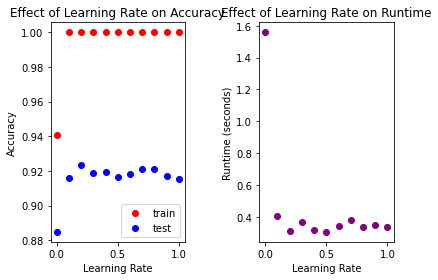

In [15]:
# Altering Learning Rate
lrs = [x / 10.0 for x in range(11)]

train_scores = []
val_scores = []
runtimes = []
for lr in lrs:
    optimizer = Optimizer(batch_size=50, learning_rate = lr, momentum = 0.9)
    scores = softmax_k_fold(digitsX, digitsy, optimizer, k=5)
    train_scores.append(scores[0])
    val_scores.append(scores[1])
    runtimes.append(scores[2])

plt.subplot(1,2,1)
train = plt.scatter(lrs, train_scores, c='red', label="train")
test = plt.scatter(lrs, val_scores, c='blue', label="test")
plt.legend(handles=[train,test])
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Effect of Learning Rate on Accuracy")
plt.tight_layout()

plt.subplot(1,2,2)
plt.scatter(lrs, runtimes, c='purple')
plt.xlabel("Learning Rate")
plt.ylabel("Runtime (seconds)")
plt.title("Effect of Learning Rate on Runtime")
plt.tight_layout()


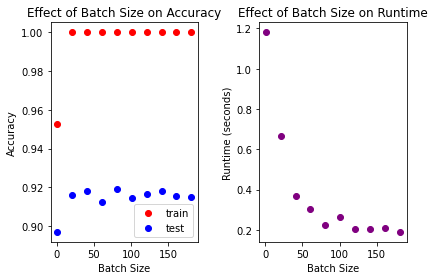

In [16]:
# Altering Batch Size
b_sizes = range(1, 200, 20)
train_scores = []
val_scores = []
runtimes = []
for bs in b_sizes:
    optimizer = Optimizer(batch_size=bs, learning_rate = 0.5, momentum = 0.9)
    scores = softmax_k_fold(digitsX, digitsy, optimizer, k=5)
    train_scores.append(scores[0])
    val_scores.append(scores[1])
    runtimes.append(scores[2])

plt.subplot(1,2,1)
train = plt.scatter(b_sizes, train_scores, c='red', label="train")
test = plt.scatter(b_sizes, val_scores, c='blue', label="test")
plt.legend(handles=[train,test])
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Effect of Batch Size on Accuracy")
plt.tight_layout()

plt.subplot(1,2,2)
plt.scatter(b_sizes, runtimes, c='purple')
plt.xlabel("Batch Size")
plt.ylabel("Runtime (seconds)")
plt.title("Effect of Batch Size on Runtime")
plt.tight_layout()

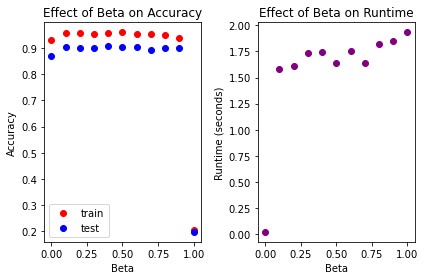

In [17]:
# Altering Beta
betas = [x / 10.0 for x in range(11)]

train_scores = []
val_scores = []
runtimes = []
for beta in betas:
    optimizer = Optimizer(batch_size=50, learning_rate = 0.5, momentum = beta)
    scores = softmax_k_fold(digitsX, digitsy, optimizer, k=5)
    train_scores.append(scores[0])
    val_scores.append(scores[1])
    runtimes.append(scores[2])

plt.subplot(1,2,1)
train = plt.scatter(betas, train_scores, c='red', label="train")
test = plt.scatter(betas, val_scores, c='blue', label="test")
plt.legend(handles=[train,test])
plt.xlabel("Beta")
plt.ylabel("Accuracy")
plt.title("Effect of Beta on Accuracy")
plt.tight_layout()

plt.subplot(1,2,2)
plt.scatter(betas, runtimes, c='purple')
plt.xlabel("Beta")
plt.ylabel("Runtime (seconds)")
plt.title("Effect of Beta on Runtime")
plt.tight_layout()

In [ ]:
#Penguins

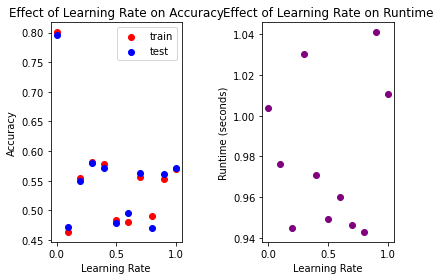

In [9]:
# Altering Learning Rate
lrs = [x / 10.0 for x in range(11)]

train_scores = []
val_scores = []
runtimes = []
for lr in lrs:
    optimizer = Optimizer(batch_size=50, learning_rate = lr, momentum = 0.9)
    scores = softmax_k_fold(penguinsX, penguinsy, optimizer, k=5)
    train_scores.append(scores[0])
    val_scores.append(scores[1])
    runtimes.append(scores[2])

plt.subplot(1,2,1)
train = plt.scatter(lrs, train_scores, c='red', label="train")
test = plt.scatter(lrs, val_scores, c='blue', label="test")
plt.legend(handles=[train,test])
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Effect of Learning Rate on Accuracy")
plt.tight_layout()

plt.subplot(1,2,2)
plt.scatter(lrs, runtimes, c='purple')
plt.xlabel("Learning Rate")
plt.ylabel("Runtime (seconds)")
plt.title("Effect of Learning Rate on Runtime")
plt.tight_layout()


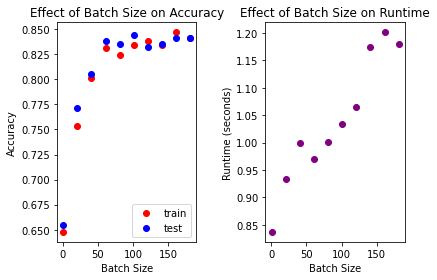

In [8]:
# Altering Batch Size
b_sizes = range(1, 200, 20)
train_scores = []
val_scores = []
runtimes = []
for bs in b_sizes:
    optimizer = Optimizer(batch_size=bs, learning_rate = 0, momentum = 0.9)
    scores = softmax_k_fold(penguinsX, penguinsy, optimizer, k=5)
    train_scores.append(scores[0])
    val_scores.append(scores[1])
    runtimes.append(scores[2])

plt.subplot(1,2,1)
train = plt.scatter(b_sizes, train_scores, c='red', label="train")
test = plt.scatter(b_sizes, val_scores, c='blue', label="test")
plt.legend(handles=[train,test])
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Effect of Batch Size on Accuracy")
plt.tight_layout()

plt.subplot(1,2,2)
plt.scatter(b_sizes, runtimes, c='purple')
plt.xlabel("Batch Size")
plt.ylabel("Runtime (seconds)")
plt.title("Effect of Batch Size on Runtime")
plt.tight_layout()

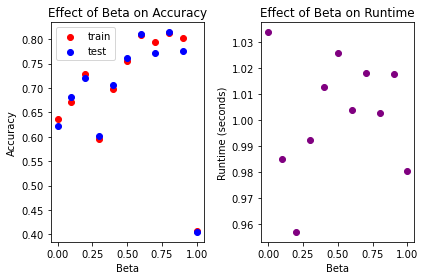

In [50]:
# Altering Beta
betas = [x / 10.0 for x in range(11)]

train_scores = []
val_scores = []
runtimes = []
for beta in betas:
    optimizer = Optimizer(batch_size=50, learning_rate = 0, momentum = beta)
    scores = softmax_k_fold(penguinsX, penguinsy, optimizer, k=5)
    train_scores.append(scores[0])
    val_scores.append(scores[1])
    runtimes.append(scores[2])

plt.subplot(1,2,1)
train = plt.scatter(betas, train_scores, c='red', label="train")
test = plt.scatter(betas, val_scores, c='blue', label="test")
plt.legend(handles=[train,test])
plt.xlabel("Beta")
plt.ylabel("Accuracy")
plt.title("Effect of Beta on Accuracy")
plt.tight_layout()

plt.subplot(1,2,2)
plt.scatter(betas, runtimes, c='purple')
plt.xlabel("Beta")
plt.ylabel("Runtime (seconds)")
plt.title("Effect of Beta on Runtime")
plt.tight_layout()